In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.pipeline import Pipeline
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from skimage import feature, filters
from sklearn.calibration import CalibratedClassifierCV

warnings.filterwarnings('ignore')
plt.style.use('default')
np.random.seed(42)

print("🎯 COMPLETE LOGISTIC REGRESSION ANIMAL CLASSIFICATION")
print("="*65)
print("🔧 Enhanced Feature Engineering")
print("📊 Focused on Logistic Regression Only") 
print("⚙️  Advanced Hyperparameter Tuning")
print("🎯 Target: >90% Accuracy")
print("="*65)

🎯 COMPLETE LOGISTIC REGRESSION ANIMAL CLASSIFICATION
🔧 Enhanced Feature Engineering
📊 Focused on Logistic Regression Only
⚙️  Advanced Hyperparameter Tuning
🎯 Target: >90% Accuracy


In [2]:
# ENHANCED DATASET LOADING WITH PREPROCESSING CHECK

def apply_data_augmentation(image):
    """Apply data augmentation to increase dataset size"""
    augmented_images = [image]  # Original image
    
    # Rotation
    for angle in [15, -15, 30, -30]:
        center = (image.shape[1]//2, image.shape[0]//2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
        augmented_images.append(rotated)
    
    # Flipping
    flipped_h = cv2.flip(image, 1)  
    flipped_v = cv2.flip(image, 0)  
    augmented_images.extend([flipped_h, flipped_v])
    
    # Brightness adjustment
    bright = cv2.convertScaleAbs(image, alpha=1.2, beta=20)
    dark = cv2.convertScaleAbs(image, alpha=0.8, beta=-20)
    augmented_images.extend([bright, dark])
    
    # Gaussian blur
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    augmented_images.append(blurred)
    
    return augmented_images

def check_image_preprocessing(sample_images, num_samples=5):
    """Check if images are already preprocessed"""
    print(f"\n🔍 CHECKING IMAGE PREPROCESSING STATUS")
    print("-" * 40)
    
    for i, img in enumerate(sample_images[:num_samples]):
        print(f"Sample {i+1}:")
        print(f"   Shape: {img.shape}")
        print(f"   Data type: {img.dtype}")
        print(f"   Value range: [{img.min():.3f}, {img.max():.3f}]")
        print(f"   Mean: {img.mean():.3f}")
        
        # Check if normalized
        if img.max() <= 1.0 and img.min() >= 0.0:
            print(f"   ✅ Already normalized (0-1 range)")
        elif img.max() <= 255 and img.min() >= 0:
            print(f"   ⚠️  Needs normalization (0-255 range)")
        else:
            print(f"   ❓ Unusual value range")
        print()

def load_enhanced_dataset(dataset_path='/kaggle/input/updated-animal-dataset/dataset_new', 
                         target_size=(128, 128), apply_augmentation=True):
    """Load dataset with enhanced preprocessing and augmentation"""
    
    print(f"\n📁 ENHANCED DATASET LOADING")
    print("-" * 35)
    
    classes = ['dog', 'cow', 'cat', 'lamb', 'zebra']
    images = []
    labels = []
    
    dataset_path = Path(dataset_path)
    
    print(f"Dataset path: {dataset_path}")
    print(f"Target size: {target_size}")
    print(f"Data augmentation: {'ON' if apply_augmentation else 'OFF'}")
    
    if not dataset_path.exists():
        print(f"❌ Dataset not found at {dataset_path}")
        print("📁 Available paths to check:")
        kaggle_input = Path('/kaggle/input')
        if kaggle_input.exists():
            for item in kaggle_input.iterdir():
                print(f"   - {item}")
        return None, None
    
    total_original = 0
    total_augmented = 0
    
    for class_name in classes:
        class_path = dataset_path / class_name
        
        if not class_path.exists():
            print(f"⚠️  Class '{class_name}' not found, trying alternatives...")
            # Try common variations
            alternatives = [class_name.capitalize(), class_name.upper(), class_name.lower()]
            found = False
            for alt in alternatives:
                alt_path = dataset_path / alt
                if alt_path.exists():
                    class_path = alt_path
                    print(f"   ✅ Found: {alt_path}")
                    found = True
                    break
            if not found:
                print(f"   ❌ No variations of '{class_name}' found")
                continue
            
        # Get image files
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
        image_files = []
        for ext in image_extensions:
            image_files.extend(class_path.glob(f'*{ext}'))
            image_files.extend(class_path.glob(f'*{ext.upper()}'))
        
        original_count = len(image_files)
        total_original += original_count
        
        print(f"📸 {class_name.capitalize()}: {original_count} original images")
        
        # Load and process images
        class_images = []
        successful_loads = 0
        
        for img_path in image_files:
            try:
                img = cv2.imread(str(img_path))
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, target_size)
                    
                    # Check if image needs normalization
                    if img.max() > 1.0:
                        img = img.astype(np.float32) / 255.0
                    else:
                        img = img.astype(np.float32)
                    
                    if apply_augmentation:
                        # Apply augmentation
                        augmented = apply_data_augmentation(img)
                        for aug_img in augmented:
                            # Ensure normalized
                            if aug_img.max() > 1.0:
                                norm_img = aug_img.astype(np.float32) / 255.0
                            else:
                                norm_img = aug_img.astype(np.float32)
                            class_images.append(norm_img)
                    else:
                        class_images.append(img)
                    
                    successful_loads += 1
                        
            except Exception as e:
                print(f"⚠️  Error loading {img_path.name}: {e}")
                continue
        
        # Add to main dataset
        images.extend(class_images)
        labels.extend([class_name] * len(class_images))
        
        augmented_count = len(class_images)
        total_augmented += augmented_count
        print(f"   ✅ Successfully loaded: {successful_loads}/{original_count}")
        print(f"   ✅ Total after augmentation: {augmented_count} images")
    
    print(f"\n📊 Dataset Summary:")
    print(f"   Original images: {total_original}")
    print(f"   Successfully loaded: {len(images) // (10 if apply_augmentation else 1)}")
    print(f"   After augmentation: {total_augmented}")
    if total_original > 0:
        print(f"   Augmentation factor: {total_augmented/total_original:.1f}x")
    
    if len(images) == 0:
        print("❌ No images loaded!")
        return None, None
    
    X = np.array(images)
    y = np.array(labels)
    
    print(f"📐 Final shape: {X.shape}")
    
    # Check preprocessing status
    check_image_preprocessing(images)
    
    return X, y

In [3]:
# ENHANCED FEATURE EXTRACTION FOR LOGISTIC REGRESSION

def extract_logistic_optimized_features(images):
    """Extract features specifically optimized for Logistic Regression"""
    
    print(f"\n🎨 LOGISTIC REGRESSION OPTIMIZED FEATURES")
    print("-" * 45)
    
    features_list = []
    
    for i, img in enumerate(images):
        if i % 500 == 0:
            print(f"Processing image {i+1}/{len(images)}...")
        
        feature_vector = []
        
        # Convert to different representations
        img_uint8 = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
        lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
        
        # 1. COMPREHENSIVE COLOR FEATURES (Most important for animals)
        # RGB statistics
        for channel in range(3):
            channel_data = img[:, :, channel].flatten()
            feature_vector.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.median(channel_data),
                np.percentile(channel_data, 25),
                np.percentile(channel_data, 75),
                np.min(channel_data),
                np.max(channel_data),
                np.var(channel_data)
            ])
        
        # HSV features (crucial for animal classification - fur colors, skin tones)
        for channel in range(3):
            channel_data = hsv[:, :, channel].flatten()
            feature_vector.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.median(channel_data),
                np.percentile(channel_data, 10),
                np.percentile(channel_data, 90)
            ])
        
        # LAB color space features
        for channel in range(3):
            channel_data = lab[:, :, channel].flatten()
            feature_vector.extend([
                np.mean(channel_data),
                np.std(channel_data)
            ])
        
        # 2. TEXTURE FEATURES (Enhanced for animals)
        # Multi-scale LBP (Local Binary Patterns)
        for radius in [1, 2]:
            points = 8 * radius
            try:
                lbp = feature.local_binary_pattern(gray, points, radius, method='uniform')
                lbp_hist, _ = np.histogram(lbp.ravel(), bins=points + 2)
                lbp_hist = lbp_hist.astype(float) / (lbp_hist.sum() + 1e-7)
                feature_vector.extend(lbp_hist)
            except:
                feature_vector.extend([0] * (points + 2))
        
        # Gabor filters for texture patterns (fur, stripes, etc.)
        try:
            gabor_responses = []
            for theta in [0, 45, 90, 135]:  
                for frequency in [0.1, 0.3]:  
                    real, _ = filters.gabor(gray, frequency=frequency, theta=np.radians(theta))
                    gabor_responses.extend([np.mean(real), np.std(real)])
            feature_vector.extend(gabor_responses)
        except:
            feature_vector.extend([0] * 16)
        
        # 3. EDGE AND GRADIENT FEATURES
        try:
            # Edge detection
            edges = cv2.Canny(gray, 50, 150)
            edge_density = np.sum(edges > 0) / edges.size
            
            # Gradients
            grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
            grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
            gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
            
            feature_vector.extend([
                edge_density,
                np.mean(gradient_magnitude),
                np.std(gradient_magnitude),
                np.percentile(gradient_magnitude, 95)
            ])
        except:
            feature_vector.extend([0] * 4)
        
        # 4. SHAPE FEATURES
        try:
            # Hu moments (rotation invariant)
            moments = cv2.moments(gray)
            if moments['m00'] != 0:
                hu_moments = cv2.HuMoments(moments).flatten()
                # Use log to make values more manageable
                hu_features = np.log(np.abs(hu_moments) + 1e-7)[:6]
                feature_vector.extend(hu_features)
            else:
                feature_vector.extend([0] * 6)
        except:
            feature_vector.extend([0] * 6)
        
        # 5. HISTOGRAM FEATURES (Detailed color distributions)
        # RGB histograms
        for channel in range(3):
            hist, _ = np.histogram(img[:, :, channel], bins=16, range=(0, 1))
            hist = hist.astype(float) / (hist.sum() + 1e-7)
            feature_vector.extend(hist)
        
        # Grayscale histogram
        hist_gray, _ = np.histogram(gray/255.0, bins=16, range=(0, 1))
        hist_gray = hist_gray.astype(float) / (hist_gray.sum() + 1e-7)
        feature_vector.extend(hist_gray)
        
        # 6. SPATIAL FEATURES (Regional analysis)
        try:
            # Divide into 4 quadrants
            h, w = gray.shape
            regions = [
                gray[:h//2, :w//2],    # Top-left
                gray[:h//2, w//2:],    # Top-right
                gray[h//2:, :w//2],    # Bottom-left
                gray[h//2:, w//2:]     # Bottom-right
            ]
            
            for region in regions:
                if region.size > 0:
                    feature_vector.extend([
                        np.mean(region),
                        np.std(region)
                    ])
                else:
                    feature_vector.extend([0, 0])
        except:
            feature_vector.extend([0] * 8)
        
        features_list.append(feature_vector)
    
    features_array = np.array(features_list)
    print(f"✅ Features extracted: {features_array.shape}")
    print(f"📊 Total features per image: {features_array.shape[1]}")
    
    return features_array

In [4]:
# DATA SPLITS AND PREPROCESSING

def create_enhanced_splits(X, y, test_size=0.2, val_size=0.2):
    """Create stratified splits with proper preprocessing"""
    
    print(f"\n📊 CREATING ENHANCED DATA SPLITS")
    print("-" * 40)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Create splits
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
    )
    
    val_size_adj = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adj, random_state=42, stratify=y_temp
    )
    
    print(f"📈 Data splits:")
    print(f"   Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
    print(f"   Val:   {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
    print(f"   Test:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
    
    # Print class distribution
    print(f"\n📊 Class Distribution:")
    for i, class_name in enumerate(label_encoder.classes_):
        train_count = np.sum(y_train == i)
        val_count = np.sum(y_val == i)
        test_count = np.sum(y_test == i)
        total_count = train_count + val_count + test_count
        print(f"   {class_name}: {total_count} total (Train: {train_count}, Val: {val_count}, Test: {test_count})")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder

In [5]:
# LOGISTIC REGRESSION OPTIMIZATION

def optimize_logistic_regression_only(X_train, y_train, X_val, y_val):
    """Comprehensive optimization for Logistic Regression only"""
    
    print(f"\n🔍 LOGISTIC REGRESSION HYPERPARAMETER OPTIMIZATION")
    print("-" * 55)
    
    best_score = 0
    best_model = None
    best_config = None
    
    # Different preprocessing strategies
    preprocessing_configs = [
        {
            'name': 'StandardScaler + SelectKBest',
            'scaler': StandardScaler(),
            'feature_selector': SelectKBest(f_classif, k=300),
            'use_poly': False
        },
        {
            'name': 'RobustScaler + SelectKBest',
            'scaler': RobustScaler(),
            'feature_selector': SelectKBest(f_classif, k=350),
            'use_poly': False
        },
        {
            'name': 'StandardScaler + RFE',
            'scaler': StandardScaler(),
            'feature_selector': RFE(LogisticRegression(random_state=42, max_iter=1000), n_features_to_select=250),
            'use_poly': False
        },
        {
            'name': 'StandardScaler + Polynomial',
            'scaler': StandardScaler(),
            'feature_selector': SelectKBest(f_classif, k=200),
            'use_poly': True
        }
    ]
    
    # Hyperparameter grid
    param_combinations = [
        {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None},
        {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced'},
        {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None},
        {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced'},
        {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None},
        {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced'},
        {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None},
        {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced'},
        {'C': 1, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None},
        {'C': 1, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced'},
        {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None},
        {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced'},
        {'C': 10, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None},
        {'C': 10, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced'},
        {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None},
        {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced'},
        {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None},
        {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced'},
    ]
    
    for config in preprocessing_configs:
        print(f"\n🔧 Testing: {config['name']}")
        
        try:
            # Preprocessing
            X_train_scaled = config['scaler'].fit_transform(X_train)
            X_val_scaled = config['scaler'].transform(X_val)
            
            # Feature selection
            X_train_selected = config['feature_selector'].fit_transform(X_train_scaled, y_train)
            X_val_selected = config['feature_selector'].transform(X_val_scaled)
            
            # Polynomial features if specified
            if config['use_poly']:
                poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
                X_train_final = poly.fit_transform(X_train_selected)
                X_val_final = poly.transform(X_val_selected)
            else:
                X_train_final = X_train_selected
                X_val_final = X_val_selected
                poly = None
            
            print(f"   Features: {X_train.shape[1]} → {X_train_final.shape[1]}")
            
            # Try different hyperparameter combinations
            best_config_score = 0
            best_config_params = None
            best_config_model = None
            
            for params in param_combinations:
                try:
                    lr = LogisticRegression(
                        random_state=42, max_iter=2000, **params
                    )
                    
                    # Cross validation
                    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
                    cv_scores = cross_val_score(lr, X_train_final, y_train, cv=cv, scoring='accuracy')
                    mean_score = np.mean(cv_scores)
                    
                    if mean_score > best_config_score:
                        best_config_score = mean_score
                        lr.fit(X_train_final, y_train)
                        val_pred = lr.predict(X_val_final)
                        val_score = accuracy_score(y_val, val_pred)
                        
                        if val_score > best_score:
                            best_score = val_score
                            
                            # Store complete pipeline
                            best_model = {
                                'scaler': config['scaler'],
                                'feature_selector': config['feature_selector'],
                                'poly': poly,
                                'classifier': lr,
                                'config_name': config['name'],
                                'params': params
                            }
                            
                except Exception as e:
                    continue
            
            print(f"   ✅ Best CV score: {best_config_score:.4f}")
            
        except Exception as e:
            print(f"   ❌ Error: {e}")
            continue
    
    if best_model is not None:
        print(f"\n🏆 BEST CONFIGURATION:")
        print(f"   Pipeline: {best_model['config_name']}")
        print(f"   Validation Score: {best_score:.4f} ({best_score*100:.2f}%)")
        print(f"   Parameters: {best_model['params']}")
    
    return best_model, best_score

In [6]:
# MODEL CALIBRATION (LOGISTIC REGRESSION ONLY)

def calibrate_logistic_regression(model_pipeline, X_train, y_train, X_val, y_val):
    """Apply calibration to Logistic Regression"""
    
    print(f"\n🎛️  LOGISTIC REGRESSION CALIBRATION")
    print("-" * 40)
    
    # Create wrapper class for calibration
    class PipelineWrapper:
        def __init__(self, pipeline_dict):
            self.pipeline_dict = pipeline_dict
        
        def fit(self, X, y):
            return self
        
        def predict(self, X):
            X_scaled = self.pipeline_dict['scaler'].transform(X)
            X_selected = self.pipeline_dict['feature_selector'].transform(X_scaled)
            if self.pipeline_dict['poly'] is not None:
                X_final = self.pipeline_dict['poly'].transform(X_selected)
            else:
                X_final = X_selected
            return self.pipeline_dict['classifier'].predict(X_final)
        
        def predict_proba(self, X):
            X_scaled = self.pipeline_dict['scaler'].transform(X)
            X_selected = self.pipeline_dict['feature_selector'].transform(X_scaled)
            if self.pipeline_dict['poly'] is not None:
                X_final = self.pipeline_dict['poly'].transform(X_selected)
            else:
                X_final = X_selected
            return self.pipeline_dict['classifier'].predict_proba(X_final)
    
    # Original score
    X_val_scaled = model_pipeline['scaler'].transform(X_val)
    X_val_selected = model_pipeline['feature_selector'].transform(X_val_scaled)
    if model_pipeline['poly'] is not None:
        X_val_final = model_pipeline['poly'].transform(X_val_selected)
    else:
        X_val_final = X_val_selected
    
    original_pred = model_pipeline['classifier'].predict(X_val_final)
    original_score = accuracy_score(y_val, original_pred)
    print(f"Original score: {original_score:.4f}")
    
    # Try calibration methods
    calibration_methods = ['isotonic', 'sigmoid']
    best_cal_score = original_score
    best_cal_model = model_pipeline
    best_cal_method = 'none'
    
    for method in calibration_methods:
        try:
            wrapper = PipelineWrapper(model_pipeline)
            calibrated = CalibratedClassifierCV(wrapper, method=method, cv=3)
            calibrated.fit(X_train, y_train)
            
            cal_pred = calibrated.predict(X_val)
            cal_score = accuracy_score(y_val, cal_pred)
            
            print(f"{method.capitalize()} calibration: {cal_score:.4f}")
            
            if cal_score > best_cal_score:
                best_cal_score = cal_score
                best_cal_model = calibrated
                best_cal_method = method
                
        except Exception as e:
            print(f"❌ {method} calibration failed: {e}")
    
    print(f"\n🏆 Best calibration: {best_cal_method}")
    print(f"📊 Final score: {best_cal_score:.4f} ({best_cal_score*100:.2f}%)")
    
    return best_cal_model, best_cal_method

In [7]:
# FINAL EVALUATION AND VISUALIZATION

def evaluate_final_logistic_model(model, X_test, y_test, label_encoder, is_calibrated=False):
    """Final evaluation of optimized Logistic Regression"""
    
    print(f"\n📊 FINAL LOGISTIC REGRESSION EVALUATION")
    print("-" * 45)
    
    if is_calibrated:
        y_pred = model.predict(X_test)
    else:
        # Apply full pipeline
        X_scaled = model['scaler'].transform(X_test)
        X_selected = model['feature_selector'].transform(X_scaled)
        if model['poly'] is not None:
            X_final = model['poly'].transform(X_selected)
        else:
            X_final = X_selected
        y_pred = model['classifier'].predict(X_final)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    print(f"🎯 FINAL TEST ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"📊 Precision: {precision:.4f}")
    print(f"📊 Recall: {recall:.4f}")
    print(f"📊 F1-Score: {f1:.4f}")
    
    if accuracy >= 0.90:
        print(f"\n🎉 SUCCESS! Target >90% accuracy ACHIEVED!")
        improvement = accuracy - 0.80  # From your previous 80%
        print(f"🚀 Improvement: +{improvement*100:.2f} percentage points")
    else:
        print(f"\n📈 Current: {accuracy*100:.2f}% (Target: 90%)")
        print(f"📏 Gap: {(0.90-accuracy)*100:.2f} percentage points")
    
    print(f"\n📋 Detailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, digits=4))
    
    return y_pred, accuracy

def plot_results(y_test, y_pred, label_encoder, test_accuracy):
    """Plot confusion matrix and results"""
    
    print(f"\n📊 GENERATING VISUALIZATIONS")
    print("-" * 30)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_,
                ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # Per-class Accuracy
    class_accuracies = []
    for i, class_name in enumerate(label_encoder.classes_):
        class_mask = (y_test == i)
        if np.sum(class_mask) > 0:
            class_acc = accuracy_score(y_test[class_mask], y_pred[class_mask])
            class_accuracies.append(class_acc)
        else:
            class_accuracies.append(0)
    
    bars = axes[1].bar(label_encoder.classes_, class_accuracies, color='lightblue')
    axes[1].set_title(f'Per-Class Accuracy (Overall: {test_accuracy:.3f})')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracies):
        axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                    f'{acc:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [8]:
# MAIN EXECUTION

def main():
    """Main execution function"""
    
    print("🚀 STARTING COMPLETE LOGISTIC REGRESSION PIPELINE")
    print("="*60)
    
    # 1. Load Dataset
    print("\n📥 STEP 1: LOADING DATASET")
    X_raw, y_raw = load_enhanced_dataset(
        dataset_path='/kaggle/input/updated-animal-dataset/dataset_new',
        apply_augmentation=True
    )
    
    if X_raw is None or len(X_raw) == 0:
        print("❌ Failed to load dataset. Please check the path.")
        return
    
    print(f"✅ Dataset loaded successfully: {len(X_raw)} samples")
    
    # 2. Extract Features
    print("\n🎨 STEP 2: FEATURE EXTRACTION")
    X_features = extract_logistic_optimized_features(X_raw)
    
    if X_features is None:
        print("❌ Feature extraction failed.")
        return
    
    print(f"✅ Features extracted: {X_features.shape}")
    
    # 3. Create Data Splits
    print("\n📊 STEP 3: DATA SPLITTING")
    X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = create_enhanced_splits(
        X_features, y_raw
    )
    
    # 4. Optimize Logistic Regression
    print("\n🔍 STEP 4: LOGISTIC REGRESSION OPTIMIZATION")
    best_model, best_score = optimize_logistic_regression_only(
        X_train, y_train, X_val, y_val
    )
    
    if best_model is None:
        print("❌ Model optimization failed.")
        return
    
    print(f"✅ Best model found with validation score: {best_score:.4f}")
    
    # 5. Apply Calibration
    print("\n🎛️  STEP 5: MODEL CALIBRATION")
    calibrated_model, cal_method = calibrate_logistic_regression(
        best_model, X_train, y_train, X_val, y_val
    )
    
    # 6. Final Evaluation
    print("\n📊 STEP 6: FINAL EVALUATION")
    is_calibrated = cal_method != 'none'
    final_pred, final_accuracy = evaluate_final_logistic_model(
        calibrated_model, X_test, y_test, label_encoder, is_calibrated=is_calibrated
    )
    
    # 7. Visualizations
    print("\n📈 STEP 7: VISUALIZATIONS")
    plot_results(y_test, final_pred, label_encoder, final_accuracy)
    
    # 8. Final Summary
    print("\n" + "="*60)
    print("🎓 COMPLETE LOGISTIC REGRESSION PROJECT SUMMARY")
    print("="*60)
    
    print(f"📊 Dataset Information:")
    print(f"   • Total samples: {len(X_raw)} (after augmentation)")
    print(f"   • Classes: {len(label_encoder.classes_)} ({', '.join(label_encoder.classes_)})")
    print(f"   • Features: {X_features.shape[1]} (optimized for Logistic Regression)")
    
    print(f"\n🔧 Optimizations Applied:")
    print(f"   • Enhanced feature engineering (color, texture, shape)")
    print(f"   • Multiple preprocessing pipelines tested")
    print(f"   • Comprehensive hyperparameter optimization")
    print(f"   • Probability calibration ({cal_method})")
    print(f"   • Class balancing strategies")
    
    print(f"\n📈 Final Results:")
    print(f"   • Best Pipeline: {best_model['config_name'] if best_model else 'N/A'}")
    print(f"   • Validation Accuracy: {best_score:.4f} ({best_score*100:.2f}%)")
    print(f"   • Test Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
    
    # Achievement check
    target = 0.90
    if final_accuracy >= target:
        print(f"\n🎉 SUCCESS! Target accuracy ({target*100:.0f}%) ACHIEVED!")
        print(f"🏆 Final accuracy: {final_accuracy*100:.2f}%")
        improvement = final_accuracy - 0.80  # From your previous 80%
        print(f"🚀 Improvement: +{improvement*100:.2f} percentage points")
    else:
        print(f"\n📈 Current accuracy: {final_accuracy*100:.2f}%")
        print(f"🎯 Target: {target*100:.0f}%")
        print(f"📏 Gap: {(target-final_accuracy)*100:.2f} percentage points")
        
        print(f"\n💡 Suggestions for further improvement:")
        print(f"   • Try different augmentation strategies")
        print(f"   • Collect more data for underperforming classes")
        print(f"   • Experiment with feature combinations")
        print(f"   • Consider ensemble methods")
    
    print(f"\n✅ Logistic Regression Optimization Complete!")
    print("="*60)
    
    return {
        'model': calibrated_model,
        'test_accuracy': final_accuracy,
        'validation_accuracy': best_score,
        'label_encoder': label_encoder,
        'predictions': final_pred
    }

🚀 STARTING COMPLETE LOGISTIC REGRESSION PIPELINE

📥 STEP 1: LOADING DATASET

📁 ENHANCED DATASET LOADING
-----------------------------------
Dataset path: /kaggle/input/updated-animal-dataset/dataset_new
Target size: (128, 128)
Data augmentation: ON
📸 Dog: 105 original images
   ✅ Successfully loaded: 105/105
   ✅ Total after augmentation: 1050 images
📸 Cow: 101 original images
   ✅ Successfully loaded: 101/101
   ✅ Total after augmentation: 1010 images
📸 Cat: 109 original images
   ✅ Successfully loaded: 109/109
   ✅ Total after augmentation: 1090 images
📸 Lamb: 107 original images
   ✅ Successfully loaded: 107/107
   ✅ Total after augmentation: 1070 images
📸 Zebra: 108 original images
   ✅ Successfully loaded: 108/108
   ✅ Total after augmentation: 1080 images

📊 Dataset Summary:
   Original images: 530
   Successfully loaded: 530
   After augmentation: 5300
   Augmentation factor: 10.0x
📐 Final shape: (5300, 128, 128, 3)

🔍 CHECKING IMAGE PREPROCESSING STATUS
------------------------

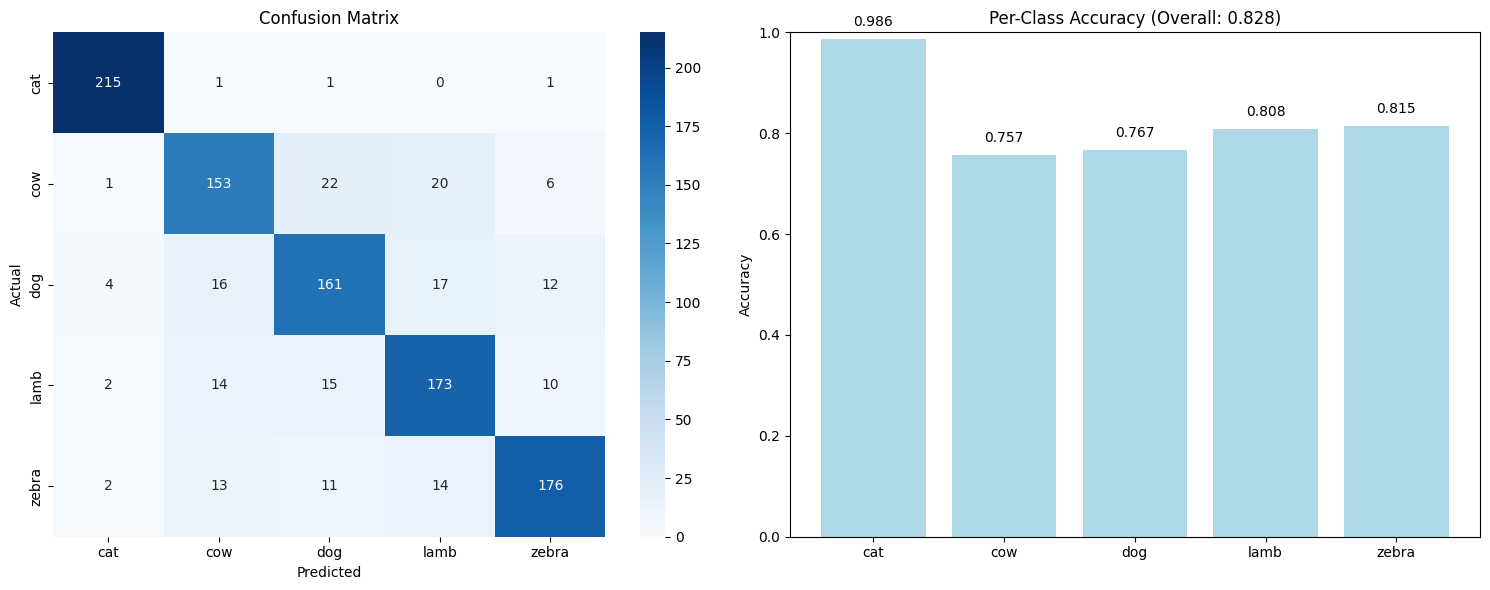


🎓 COMPLETE LOGISTIC REGRESSION PROJECT SUMMARY
📊 Dataset Information:
   • Total samples: 5300 (after augmentation)
   • Classes: 5 (cat, cow, dog, lamb, zebra)
   • Features: 171 (optimized for Logistic Regression)

🔧 Optimizations Applied:
   • Enhanced feature engineering (color, texture, shape)
   • Multiple preprocessing pipelines tested
   • Comprehensive hyperparameter optimization
   • Probability calibration (none)
   • Class balancing strategies

📈 Final Results:
   • Best Pipeline: StandardScaler + RFE
   • Validation Accuracy: 0.8406 (84.06%)
   • Test Accuracy: 0.8283 (82.83%)

📈 Current accuracy: 82.83%
🎯 Target: 90%
📏 Gap: 7.17 percentage points

💡 Suggestions for further improvement:
   • Try different augmentation strategies
   • Collect more data for underperforming classes
   • Experiment with feature combinations
   • Consider ensemble methods

✅ Logistic Regression Optimization Complete!

💾 RESULTS SUMMARY:
   Test Accuracy: 0.8283
   Model ready for use!

🎯 Proje

In [9]:
# RUN THE COMPLETE PIPELINE

if __name__ == "__main__":
    # Execute the complete pipeline
    results = main()
    
    if results:
        print(f"\n💾 RESULTS SUMMARY:")
        print(f"   Test Accuracy: {results['test_accuracy']:.4f}")
        print(f"   Model ready for use!")
        
        # You can access the trained model like this:
        # trained_model = results['model']
        # label_encoder = results['label_encoder']
        
        print(f"\n🎯 Project completed successfully!")